## Fit RT and DA prices historical/empirical distribution. 

We want to find distribution that fits the best those prices

In [1]:
import os
import requests
from datetime import datetime, timedelta
from glob import glob
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t, logistic, gamma, lognorm, kstest


c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
node_RT = pd.read_csv("../data/Node_RT.csv")
node_DA = pd.read_csv("../data/Node_DA_LMP.csv")

node_RT_LMP = node_RT[node_RT['VALUE'] == 'LMP']
node_RT_LMP = node_RT_LMP.drop(columns=node_RT_LMP.columns[0])#.set_index('MARKET_DAY')
node_RT_LMP['date'] = pd.to_datetime(node_RT_LMP['MARKET_DAY']) 
node_RT_LMP['Month'] = node_RT_LMP['date'].dt.month
node_DA_LMP = node_DA
node_DA_LMP['date'] = pd.to_datetime(node_DA_LMP['MARKET_DAY'])
node_DA_LMP['Month'] = node_DA_LMP['date'].dt.month


In [3]:
node_RT_LMP.head()

,MARKET_DAY,NODE,TYPE,VALUE,HE1,HE2,HE3,HE4,HE5,HE6,...,HE17,HE18,HE19,HE20,HE21,HE22,HE23,HE24,date,Month
0,10/1/2022,NSP.NWELOAD,Loadzone,LMP,17.69,13.95,22.03,33.19,39.61,42.65,...,47.95,50.86,52.23,46.37,38.11,35.04,22.29,24.85,2022-10-01,10
3,10/2/2022,NSP.NWELOAD,Loadzone,LMP,13.95,24.15,23.93,23.76,24.22,26.24,...,46.88,57.03,50.22,46.5,27.70,3.76,-3.77,-5.24,2022-10-02,10
6,10/3/2022,NSP.NWELOAD,Loadzone,LMP,-7.72,-9.24,-7.93,-3.80,-2.91,18.86,...,53.72,63.74,126.80,53.33,38.58,48.7,38.09,21.06,2022-10-03,10
9,10/4/2022,NSP.NWELOAD,Loadzone,LMP,32.22,25.06,32.58,27.78,27.99,29.48,...,60.71,72.3,64.68,120.26,49.77,45.95,47.16,46.71,2022-10-04,10
12,10/5/2022,NSP.NWELOAD,Loadzone,LMP,41.72,37.47,32.99,33.93,36.3,65.63,...,59.83,63.48,61.48,80.77,109.09,47.44,34.41,31.65,2022-10-05,10


## fiting a normal distribution

In [4]:
import pandas as pd
from scipy.stats import norm, kstest, normaltest

# 1. Charger votre DataFrame (ex. depuis un CSV) :
# df = pd.read_csv("Node_DA_LMP.csv", parse_dates=['date'])

# 2. Repasser du format « wide » (HE1..HE24) au format « long »
hour_cols = [f'HE{i}' for i in range(1, 25)]
df_long = node_DA_LMP.melt(
    id_vars   = ['date', 'Month'],
    value_vars= hour_cols,
    var_name  = 'Hour',
    value_name= 'LMP'
)
# Extraire le numéro d’heure
df_long['Hour'] = df_long['Hour'].str.extract(r'HE(\d+)').astype(int)
df_long = df_long.dropna(subset=['LMP'])  # au cas où
display(df_long.head())
# 3. Fonction d’ajustement + tests
def fit_and_test(group):
    data = group['LMP'].values
    # Estimation des paramètres μ et σ
    mu, sigma = norm.fit(data)
    # Test de Kolmogorov–Smirnov
    ks_stat, ks_p = kstest(data, 'norm', args=(mu, sigma))
    # Test de D’Agostino–Pearson
    dt_stat, dt_p = normaltest(data)
    return pd.Series({
        'count'           : len(data),
        'mu'              : mu,
        'sigma'           : sigma,
        'ks_stat'         : ks_stat,
        'ks_pvalue'       : ks_p,
        'dagostino_stat'  : dt_stat,
        'dagostino_pvalue': dt_p
    })

# 4. Application à chaque groupe (Mois, Heure)
result = (
    df_long
      .groupby(['Month', 'Hour'])
      .apply(fit_and_test)
      .reset_index()
)

# 5. Affichage des résultats
print(result)



,date,Month,Hour,LMP
0,2022-10-01,10,1,26.23
1,2022-10-02,10,1,23.31
2,2022-10-03,10,1,7.02
3,2022-10-04,10,1,15.53
4,2022-10-05,10,1,36.77


     Month  Hour  count         mu      sigma   ks_stat  ks_pvalue  \
0        1     1   93.0  38.706022  25.954810  0.225469   0.000123   
1        1     2   93.0  35.495484  23.180394  0.228743   0.000093   
2        1     3   93.0  33.892151  22.977458  0.219618   0.000203   
3        1     4   93.0  33.875914  22.873922  0.221777   0.000169   
4        1     5   93.0  34.423226  23.791881  0.221374   0.000175   
..     ...   ...    ...        ...        ...       ...        ...   
283     12    20   93.0  44.738710  23.044430  0.131645   0.072569   
284     12    21   93.0  41.776344  21.077555  0.138792   0.050306   
285     12    22   93.0  39.051828  18.440862  0.154467   0.021036   
286     12    23   93.0  36.054624  18.103697  0.166868   0.009872   
287     12    24   93.0  33.579677  14.398274  0.149967   0.027279   

     dagostino_stat  dagostino_pvalue  
0         82.749085      1.074644e-18  
1         85.740359      2.408338e-19  
2         96.521648      1.097970e-21  

C:\Users\benja\AppData\Local\Temp\ipykernel_4968\2671609409.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fit_and_test)


In [ ]:


# ---------------------------------------------------------------------
# 2. Passer en format long
# ---------------------------------------------------------------------
hour_cols = [f'HE{i}' for i in range(1, 25)]
df_long = (
    node_DA_LMP
    .melt(id_vars=['date', 'Month'], value_vars=hour_cols,
          var_name='Hour', value_name='LMP')
    .assign(Hour=lambda d: d['Hour'].str.extract(r'HE(\d+)').astype(int))
    .dropna(subset=['LMP'])
)

# ---------------------------------------------------------------------
# 3. Dictionnaires (nom SciPy → objet de distr.)
# ---------------------------------------------------------------------
DISTS_R   = {   # support ℝ
    'norm'     : norm,
    't'        : t,
    'logistic' : logistic,
}
DISTS_POS = {   # support ℝ⁺
    'gamma'   : gamma,
    'lognorm' : lognorm,
}

def fit_and_test(data):
    """Renvoie un dict {dist_stat, dist_p, …, best_fit} pour un 1-D ndarray."""
    out = {}

    # 3a. Lois sur ℝ
    for name, dist in DISTS_R.items():
        params        = dist.fit(data)
        stat, pvalue  = kstest(data, name, args=params)   # ← nom exact !
        out[f'{name}_stat'] = stat
        out[f'{name}_p']    = pvalue

    # 3b. Lois sur ℝ⁺
    if (data > 0).all():
        for name, dist in [('gamma', gamma), ('lognorm', lognorm)]:
            # on autorise loc libre -> support = (loc, ∞) donc tolère les valeurs négatives
            params = dist.fit(data)                 # retourne (shape, loc, scale)
            stat, pval = kstest(data, name, args=params)
            out[f'{name}_stat'] = stat
            out[f'{name}_p']    = pval

    # 3c. Meilleure loi = p-value KS maximale
    pvals = {k: v for k, v in out.items() if k.endswith('_p')}
    best  = max(pvals, key=lambda k: pvals[k] if not np.isnan(pvals[k]) else -1)
    out['best_fit'] = best.replace('_p', '')

    return out

# ---------------------------------------------------------------------
# 4. Application par (Month, Hour)
# ---------------------------------------------------------------------
result = (
    df_long
    .groupby(['Month', 'Hour'])['LMP']
    .apply(lambda s: pd.Series(fit_and_test(s.values)))
    .reset_index()
)



In [11]:
df_long

,date,Month,Hour,LMP
0,2022-10-01,10,1,26.23
1,2022-10-02,10,1,23.31
2,2022-10-03,10,1,7.02
3,2022-10-04,10,1,15.53
4,2022-10-05,10,1,36.77
...,...,...,...,...
21907,2025-03-27,3,24,25.61
21908,2025-03-28,3,24,26.70
21909,2025-03-29,3,24,24.39
21910,2025-03-30,3,24,26.83


In [10]:
## Summary of best fits in percentage
best = result[result['level_2'] == 'best_fit']

# 2. Comptage du nombre de (Month, Hour) où chaque loi est gagnante
summary = (
    best['LMP']                      # ← ici LMP contient le nom de la loi gagnante
        .value_counts(normalize=True)
        .mul(100)                    # pourcentage
        .round(1)
        .rename_axis('Distribution')
        .rename('Percent_of_groups')
        .reset_index()
)

print("\nSummary (% of groups for which it has the best law) :")
print(summary)



Summary (% of groups for which it has the best law) :
  Distribution  Percent_of_groups
0      lognorm               35.4
1     logistic               30.9
2            t               21.5
3        gamma               10.4
4         norm                1.7


We will choose the logistic regression because it allows negative prices

## Fit a time series model

Wwe know that electricity prices exhibit seasonality and auto-correlation

#### Partial Auto-Correlation Function 

In [13]:
node_DA_LMP.head()

,MARKET_DAY,NODE,TYPE,VALUE,HE1,HE2,HE3,HE4,HE5,HE6,...,HE18,HE19,HE20,HE21,HE22,HE23,HE24,source_zip,date,Month
0,10/1/2022,NSP.NWELOAD,Loadzone,LMP,26.23,26.36,27.48,28.07,30.72,33.15,...,51.31,51.11,45.59,38.73,28.53,23.63,23.11,2022_Oct-Dec_DA_LMPs.zip,2022-10-01,10
1,10/2/2022,NSP.NWELOAD,Loadzone,LMP,23.31,22.69,24.87,25.31,27.82,28.90,...,59.67,62.23,50.72,41.04,30.59,20.68,18.41,2022_Oct-Dec_DA_LMPs.zip,2022-10-02,10
2,10/3/2022,NSP.NWELOAD,Loadzone,LMP,7.02,7.78,8.20,11.31,19.78,30.68,...,71.42,77.23,63.58,49.66,41.60,29.13,27.66,2022_Oct-Dec_DA_LMPs.zip,2022-10-03,10
3,10/4/2022,NSP.NWELOAD,Loadzone,LMP,15.53,15.63,16.39,20.82,29.23,44.59,...,73.17,77.02,63.05,54.37,48.23,45.76,44.78,2022_Oct-Dec_DA_LMPs.zip,2022-10-04,10
4,10/5/2022,NSP.NWELOAD,Loadzone,LMP,36.77,35.53,33.56,34.78,39.71,54.43,...,68.47,69.01,60.72,49.12,43.26,33.95,29.17,2022_Oct-Dec_DA_LMPs.zip,2022-10-05,10


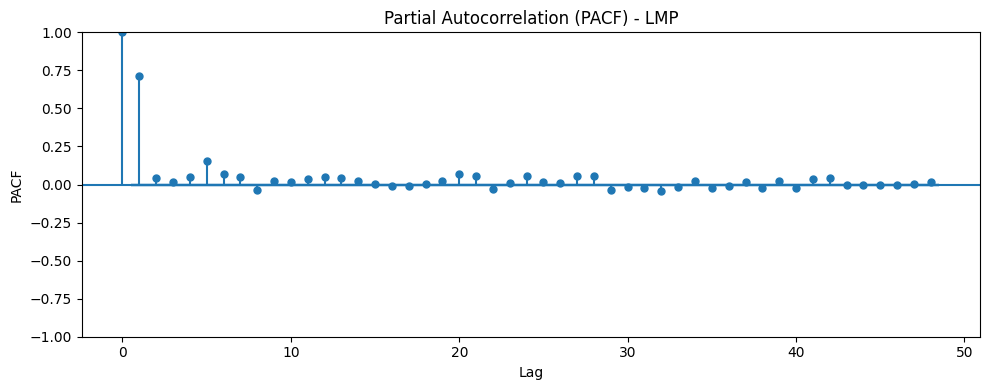

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf


# For this example we assume `df` is already in memory:
assert 'LMP' in df_long.columns, "DataFrame must contain an 'LMP' column."

# Ensure the index is datetime for proper PACF
if not isinstance(df_long.index, pd.DatetimeIndex):
    if 'date' in df_long.columns:
        df = df_long.set_index('date')
    else:
        raise ValueError("DataFrame needs a datetime index or a 'ds' column.")

# ------------------------------------------------------------------
# 2. Plot PACF
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 4))
plot_pacf(df['LMP'], ax=ax, lags=48, method='ywm')
ax.set_title('Partial Autocorrelation (PACF) - LMP')
ax.set_xlabel('Lag')
ax.set_ylabel('PACF')
plt.tight_layout()
plt.show()


#### Fit time series model

In [23]:
from prophet import Prophet        
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ------------------------------------------------------------------
# 1. Prepare the time series  (date + hour → timestamp)
# ------------------------------------------------------------------
df = df_long.copy()
df['ds'] = pd.to_datetime(df['date']) + pd.to_timedelta(df['Hour']-1, unit='h')
df = df[['ds', 'LMP']].rename(columns={'LMP': 'y'}).sort_values('ds')

# ------------------------------------------------------------------
# 2. 70 % / 30 % chronological split
# ------------------------------------------------------------------
cutoff = int(len(df)*0.70)
train  = df.iloc[:cutoff].copy()
test   = df.iloc[cutoff:].copy()

# ------------------------------------------------------------------
# 3. Fit Prophet with hourly, weekly & yearly seasonality
# ------------------------------------------------------------------
m = Prophet(
    growth            = "linear",
    changepoint_prior_scale = 0.05,
    daily_seasonality = False,   # we build custom 24 h seasonality
    weekly_seasonality= True,
    yearly_seasonality= True,
    uncertainty_samples=1_000,   # <-- set here, not in predictive_samples
)

# 24-hour (hour-of-day) seasonality
m.add_seasonality(name='hourly', period=24, fourier_order=12)

m.fit(train)

# m = Prophet(
#         growth             = "linear",
#         daily_seasonality  = False,
#         weekly_seasonality = True,
#         yearly_seasonality = True,
#         uncertainty_samples=1_000     # <-- set here, not in predictive_samples
#      )
# m.add_seasonality(name='hourly', period=24, fourier_order=12)
# m.fit(df_long)

# ------------------------------------------------------------------
# 4. Evaluate on the test set
# ------------------------------------------------------------------
future = test[['ds']].copy()        # same timestamps as test
forecast = m.predict(future)

mae = mean_absolute_error(test['y'], forecast['yhat'])
rmse = mean_squared_error(test['y'], forecast['yhat'], squared=False)
print(f"Test MAE  : {mae:,.2f}")
print(f"Test RMSE : {rmse:,.2f}")




19:39:51 - cmdstanpy - INFO - Chain [1] start processing
19:39:57 - cmdstanpy - INFO - Chain [1] done processing


Test MAE  : 37.27
Test RMSE : 48.90


In [25]:
HORIZON_H = 24*365
future    = m.make_future_dataframe(periods=HORIZON_H, freq="H", include_history=False)

# ------------------------------------------------------------
# 4.  Draw posterior-predictive samples
#     The number of paths = m.uncertainty_samples
# ------------------------------------------------------------
samples = m.predictive_samples(future)     # no n_samples argument
paths   = samples['yhat'].T                # shape (n_paths, HORIZON_H)
n_paths = paths.shape[0]                   # usually 1 000

# (optional) force every path to start at a desired level P0
P0     = 40
shift  = P0 - paths[:, 0]
paths  = paths + shift[:, None]

print("Simulated matrix:", paths.shape)    # (n_paths, 8760)
print("First path, first 5 values:", paths[0, :5])

Simulated matrix: (1000, 8760)
First path, first 5 values: [40.         22.41406027  5.60698776 16.22298441 10.2219813 ]


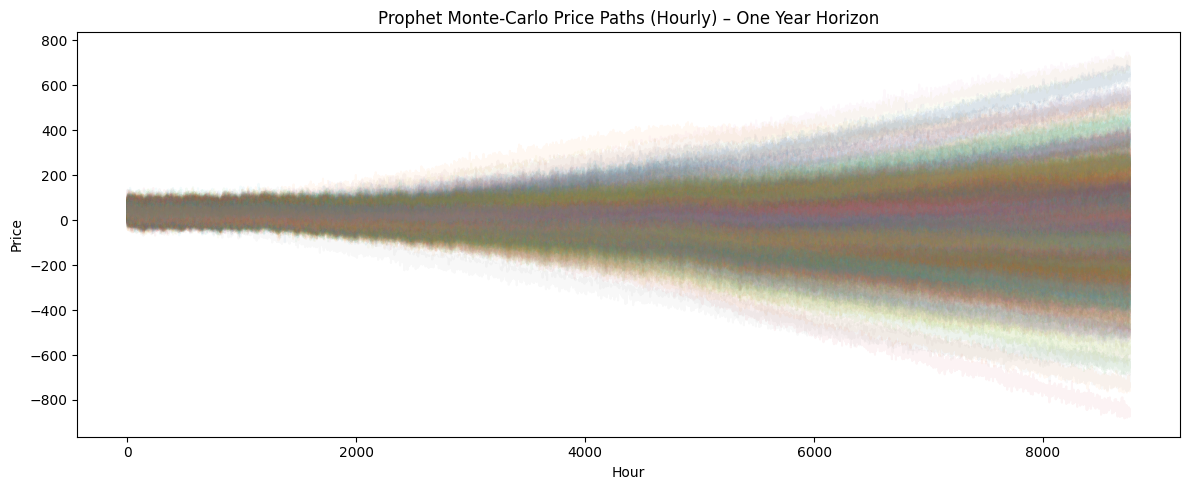

In [28]:

# Ensure 'paths' exists; otherwise raise an error
try:
    paths
except NameError:
    raise RuntimeError("Variable 'paths' was not found. Please run the simulation block first.")

fig, ax = plt.subplots(figsize=(12, 5))

# Plot each Monte‑Carlo path
for path in paths:
    ax.plot(path, alpha=0.05)

ax.set_title('Prophet Monte‑Carlo Price Paths (Hourly) – One Year Horizon')
ax.set_xlabel('Hour')
ax.set_ylabel('Price')
plt.tight_layout()
plt.show()


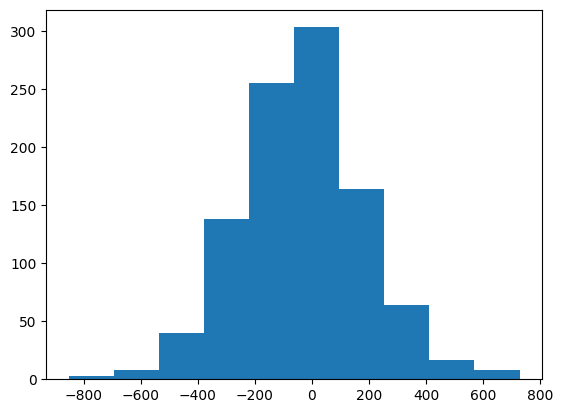

In [29]:
plt.hist(paths[:,-1])
plt.show()